# Set-up

## Imports

In [1]:
# Standard
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
from tqdm.notebook import tqdm, trange
import plotly.graph_objects as go

# Sci-kit learn
from sklearn.neighbors import KernelDensity
from sklearn.metrics import average_precision_score

## Parameters

In [16]:
scope = 'BID'
input_path = f'../../data/3_output/ML_dataset_{scope}.pkl'

start_month = 201901
end_month = 202212

subsample_size = None

## Functions

In [17]:
def fit_bayes_clf(X, y, bins=50):
    """Takes a 1d array of a univariate feature along with a binary target and returns the prior probabilities with the two conditional empirical distributions"""
    prior_prob = sum(y) / len(y)
    # Empirical distribution of class 1
    hist0, edges0 = np.histogram(X[y==0], bins=bins, density=True)
    # Empirical distribution of class 2
    hist1, edges1 = np.histogram(X[y==1], bins=bins, density=True)
    return prior_prob, hist0, edges0, hist1, edges1

In [18]:
def get_epdf(hist, edges, X):
    """From an empirical distribution and an array of values, return the densities of the values induced by the empirical distributiion"""
    indexes = np.searchsorted(edges, X)
    # Values outside the support of the empirical distribution will be assigned a density corresponding the closest value in the support (so either the minimum or the maximum of the support)
    res = np.array([hist[min(max(i - 1, 0), len(hist)-1)] for i in indexes])
    return res

In [19]:
def predict_bayes_clf(X, prior_prob, hist0, edges0, hist1, edges1):
    """From an array of X values, estimated prior probabilities and conditional distributions, estimate the class probability using Bayes formula"""
    # Array of the estimate of the conditional distribution of class 0 evaluated at X values
    f0 = get_epdf(hist0, edges0, X)
    # Array of the estimate of the conditional distribution of class 1 evaluated at X values
    f1 = get_epdf(hist1, edges1, X)
    # Bayes formula for posterior probability p(y|x)
    res = prior_prob * f1 / (prior_prob * f1 + (1-prior_prob) * f0)
    # In the case of null numerator and denominator (f0=f1=0), we just assign the prior probability
    res[np.isnan(res)] = prior_prob
    return res

In [20]:
def get_X_y(df):
    return df["PriceDiff"], df['Result']

In [21]:
def predict_proba_monthly_recal(df):
    """
    For each observation of the dataset, if M is the corresponding month, outputs the predicted probability of the model when trained on the M-12 to M-1 period.
    We hence fit a number of models equal to the number of months in the dataset.
    This allows to test the the performance of the model in a "live" setting, where each month, the model is recalibrated with the new data.
    """
    observation_month = df.index.str[:6].astype(int)
    months = sorted(observation_month.unique())
    test_months = [month for month in  months if month >= start_month and month <= end_month]
    y_probs_list =  []

    for test_month in tqdm(test_months):
        # For every month M, we take the training period as M-12 to M-1
        idx = months.index(test_month)
        train_months = months[idx-12:idx]
        X_train, y_train = get_X_y(df[observation_month.isin(train_months)])
        # And the test period as month M
        X_test, y_test = get_X_y(df[observation_month == test_month])

        prior_prob, hist0, edges0, hist1, edges1 = fit_bayes_clf(X_train, y_train)

        y_probs = predict_bayes_clf(X_test, prior_prob, hist0, edges0, hist1, edges1)
        
        APS = average_precision_score(y_test, y_probs)
        print('Average Precision Score over {:,} samples for month {} is: {}'.format(len(y_test), test_month, round(APS, 3)))
        print("\n")
        
        y_probs_list.append(y_probs)
    
    return pd.Series(np.concatenate(y_probs_list, axis=0), index=df[observation_month.isin(test_months)].index)

# Main

# Load data

In [22]:
# Load dataset
input_df = pd.read_pickle(input_path)
df = input_df.copy()
df['yearmonth'] = df.index.str[:6].astype(int)
df['month'] = df.index.str[4:6].astype(int)
df

,hour,date,year,unit,scope,SC_PC1,SC_PC2,IN_PC1,IN_PC2,CT_PC1,...,WorkDay,Prov,Tech,PVold,PVnew,Price,PriceDiff,Result,yearmonth,month
2018010118UP_ALTOADDA_1_BID,18,20180101,2018,UP_ALTOADDA_1,BID,2.083112,0.480035,-1.932233,-0.782315,1.912031,...,holiday,Milano,Hydro Run-of-river and poundage,0.095,0.095,26.22,-0.349,False,201801,1
2018010119UP_ALTOADDA_1_BID,19,20180101,2018,UP_ALTOADDA_1,BID,1.249924,0.598779,-1.772487,-0.866850,0.891173,...,holiday,Milano,Hydro Run-of-river and poundage,0.095,0.095,26.22,-0.329,False,201801,1
2018010120UP_ALTOADDA_1_BID,20,20180101,2018,UP_ALTOADDA_1,BID,0.243493,0.768175,-1.758348,-0.872364,-0.334594,...,holiday,Milano,Hydro Run-of-river and poundage,0.095,0.095,26.22,-0.324,False,201801,1
2018010117UP_ARSIE_1_BID,17,20180101,2018,UP_ARSIE_1,BID,3.456008,0.661794,-2.372137,-0.624680,3.037220,...,holiday,Belluno,Hydro Run-of-river and poundage,0.627,0.627,0.00,-1.000,False,201801,1
2018010118UP_ARSIE_1_BID,18,20180101,2018,UP_ARSIE_1,BID,2.083112,0.480035,-1.932233,-0.782315,1.912031,...,holiday,Belluno,Hydro Run-of-river and poundage,1.000,1.000,0.00,-1.000,False,201801,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022123117UP_VOGHERA_1_BID,17,20221231,2022,UP_VOGHERA_1,BID,0.237656,-2.008471,-1.806319,0.875068,-2.527147,...,holiday,Pavia,Fossil Gas,0.540,0.540,135.00,-0.350,False,202212,12
2022123118UP_VOGHERA_1_BID,18,20221231,2022,UP_VOGHERA_1,BID,0.055686,-2.259989,-1.329127,0.607693,-2.561474,...,holiday,Pavia,Fossil Gas,1.000,1.000,136.00,-0.420,True,202212,12
2022123119UP_VOGHERA_1_BID,19,20221231,2022,UP_VOGHERA_1,BID,-0.051126,-2.357014,-1.293692,0.548271,-2.484197,...,holiday,Pavia,Fossil Gas,1.000,1.000,138.00,-0.414,True,202212,12
2022123120UP_VOGHERA_1_BID,20,20221231,2022,UP_VOGHERA_1,BID,-0.029177,-2.330178,-1.385200,0.630366,-2.484197,...,holiday,Pavia,Fossil Gas,1.000,1.000,141.00,-0.405,True,202212,12


## Predict

In [23]:
y_probs = predict_proba_monthly_recal(df)

  0%|          | 0/48 [00:00<?, ?it/s]

Average Precision Score over 46,525 samples for month 201901 is: 0.187


Average Precision Score over 38,675 samples for month 201902 is: 0.28


Average Precision Score over 39,137 samples for month 201903 is: 0.351


Average Precision Score over 42,489 samples for month 201904 is: 0.377


Average Precision Score over 46,778 samples for month 201905 is: 0.328


Average Precision Score over 48,778 samples for month 201906 is: 0.172


Average Precision Score over 54,320 samples for month 201907 is: 0.265


Average Precision Score over 40,523 samples for month 201908 is: 0.338


Average Precision Score over 37,283 samples for month 201909 is: 0.291


Average Precision Score over 34,730 samples for month 201910 is: 0.372


Average Precision Score over 35,962 samples for month 201911 is: 0.469


Average Precision Score over 36,277 samples for month 201912 is: 0.448


Average Precision Score over 40,846 samples for month 202001 is: 0.391


Average Precision Score over 33,777 samples for mont

/var/folders/q5/hqwjttz50sg2x53x_jw4yz300000gn/T/ipykernel_11610/1075435821.py:8: RuntimeWarning: invalid value encountered in divide
  res = prior_prob * f1 / (prior_prob * f1 + (1-prior_prob) * f0)


Average Precision Score over 30,523 samples for month 202005 is: 0.3


Average Precision Score over 37,372 samples for month 202006 is: 0.358


Average Precision Score over 43,157 samples for month 202007 is: 0.326


Average Precision Score over 37,697 samples for month 202008 is: 0.461


Average Precision Score over 35,846 samples for month 202009 is: 0.422


Average Precision Score over 30,707 samples for month 202010 is: 0.501


Average Precision Score over 35,487 samples for month 202011 is: 0.488


Average Precision Score over 35,303 samples for month 202012 is: 0.391


Average Precision Score over 36,118 samples for month 202101 is: 0.414


Average Precision Score over 30,635 samples for month 202102 is: 0.467


Average Precision Score over 34,285 samples for month 202103 is: 0.488


Average Precision Score over 32,706 samples for month 202104 is: 0.405


Average Precision Score over 29,759 samples for month 202105 is: 0.44


Average Precision Score over 33,056 samples for month 

/var/folders/q5/hqwjttz50sg2x53x_jw4yz300000gn/T/ipykernel_11610/1075435821.py:8: RuntimeWarning: invalid value encountered in divide
  res = prior_prob * f1 / (prior_prob * f1 + (1-prior_prob) * f0)


Average Precision Score over 27,640 samples for month 202205 is: 0.424


Average Precision Score over 29,643 samples for month 202206 is: 0.43


Average Precision Score over 32,136 samples for month 202207 is: 0.418


Average Precision Score over 27,629 samples for month 202208 is: 0.411


Average Precision Score over 25,016 samples for month 202209 is: 0.447


Average Precision Score over 23,828 samples for month 202210 is: 0.44


Average Precision Score over 25,228 samples for month 202211 is: 0.469


Average Precision Score over 27,919 samples for month 202212 is: 0.456




In [15]:
y_probs.to_pickle(f'../{scope}/model_predictions/HP_predicted_probs_monthly_recal_rolling_12m.pkl')

___

# TESTS

In [16]:
observation_month = df.index.str[:6].astype(int)
months = sorted(observation_month.unique())
test_months = [month for month in  months if month >= start_month and month <= end_month]
df_test = df[observation_month.isin(test_months)]
df_test[y_probs.isna()]

,hour,date,year,unit,scope,SC_PC1,SC_PC2,IN_PC1,IN_PC2,CT_PC1,...,WorkDay,Prov,Tech,PVold,PVnew,Price,PriceDiff,Result,yearmonth,month
2022082220UP_MASOCORON_1_OFF,20,20220822,2022,UP_MASOCORON_1,OFF,3.854093,0.001071,-0.096819,0.312236,1.082408,...,weekday,Trento,Hydro Water Reservoir,0.995,0.995,201.0,-0.565,False,202208,8
2022082221UP_MASOCORON_1_OFF,21,20220822,2022,UP_MASOCORON_1,OFF,1.562964,-1.099152,-0.302471,0.332820,1.099871,...,weekday,Trento,Hydro Water Reservoir,0.995,0.995,201.0,-0.544,False,202208,8
202208238UP_MASOCORON_1_OFF,8,20220823,2022,UP_MASOCORON_1,OFF,4.666510,0.489625,-1.201706,0.098754,1.309921,...,weekday,Trento,Hydro Water Reservoir,0.995,0.995,201.0,-0.538,False,202208,8
202208239UP_MASOCORON_1_OFF,9,20220823,2022,UP_MASOCORON_1,OFF,5.185949,-0.778317,-0.551501,0.012816,1.275594,...,weekday,Trento,Hydro Water Reservoir,0.995,0.995,201.0,-0.544,False,202208,8
2022082319UP_MASOCORON_1_OFF,19,20220823,2022,UP_MASOCORON_1,OFF,4.814026,-0.019380,0.892820,0.359544,1.935654,...,weekday,Trento,Hydro Water Reservoir,0.000,0.000,201.0,-0.560,False,202208,8
2022082320UP_MASOCORON_1_OFF,20,20220823,2022,UP_MASOCORON_1,OFF,5.016727,-2.291357,0.358513,-0.286856,1.901327,...,weekday,Trento,Hydro Water Reservoir,0.000,0.000,201.0,-0.582,False,202208,8


In [10]:
df[df.PriceDiff.isna()]

,hour,date,year,unit,scope,SC_PC1,SC_PC2,IN_PC1,IN_PC2,CT_PC1,...,WorkDay,Prov,Tech,PVold,PVnew,Price,PriceDiff,Result,yearmonth,month


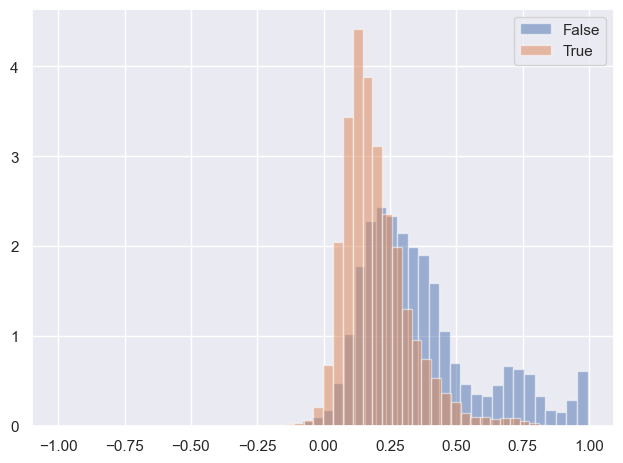

In [38]:
df[df.year==2018].groupby('Result')['PriceDiff'].hist(density=True, bins=50, alpha=0.5, legend=True)
plt.tight_layout()

<Axes: xlabel='year', ylabel='PriceDiff'>

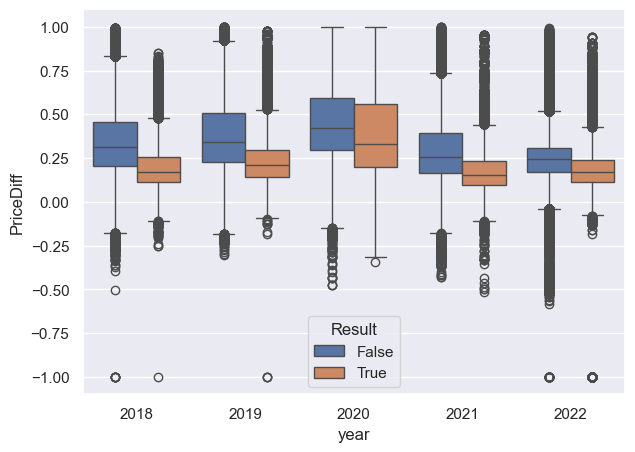

In [30]:
plt.figure(figsize=(7, 5))
sns.boxplot(df, x='year', hue='Result', y='PriceDiff')